<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Train/Test-Split" data-toc-modified-id="Train/Test-Split-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train/Test Split</a></span><ul class="toc-item"><li><span><a href="#SPY" data-toc-modified-id="SPY-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>SPY</a></span></li><li><span><a href="#TNX" data-toc-modified-id="TNX-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>TNX</a></span></li><li><span><a href="#VIX" data-toc-modified-id="VIX-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>VIX</a></span></li><li><span><a href="#IRX" data-toc-modified-id="IRX-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>IRX</a></span></li></ul></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Methodology</a></span><ul class="toc-item"><li><span><a href="#VIX:-I" data-toc-modified-id="VIX:-I-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>VIX: I</a></span></li><li><span><a href="#VIX:-II" data-toc-modified-id="VIX:-II-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>VIX: II</a></span></li><li><span><a href="#SPY:-I" data-toc-modified-id="SPY:-I-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>SPY: I</a></span></li><li><span><a href="#SPY:-II" data-toc-modified-id="SPY:-II-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>SPY: II</a></span></li><li><span><a href="#TNX:-I" data-toc-modified-id="TNX:-I-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>TNX: I</a></span></li><li><span><a href="#TNX:-II" data-toc-modified-id="TNX:-II-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>TNX: II</a></span></li><li><span><a href="#IRX:-I" data-toc-modified-id="IRX:-I-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>IRX: I</a></span></li><li><span><a href="#IRX:-II" data-toc-modified-id="IRX:-II-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>IRX: II</a></span></li></ul></li></ul></div>

# Fit the model

We explore the minutes and statements while we find them are not suitable for training and testing models. The sample size is too small, and the variance, or the principle generating documents, varies with time. Then we throw our sight on the speeches of federal reserve officials, whose length is much more consistent and quantity is higher.

We select three indexes to sketch the effect of the FOMC's documents on the market: S&P 500 Index(SPY), Treasury Yield 3 months (IRX), Treasury Yield 10 Years (TNX), CBOE Volatility Index (VIX). The data is from [Yahoo Finance](https://finance.yahoo.com/)

In [24]:
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.models.word2vec import Word2Vec
from keras.layers import Input, Dense, concatenate, Activation, Dropout, Flatten, Conv1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import utils
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from frb_functions import *

In [4]:
spy_df = pd.read_csv('./data/SPY.csv')
spy_df.fillna(method='pad')
spy_df["SPY"] = spy_df["Adj Close"].pct_change() * 100
spy_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
spy_df.drop(0, inplace=True)
vix_df = pd.read_csv('./data/^VIX.csv')
vix_df.fillna(method='pad')
vix_df["VIX"] = vix_df["Adj Close"].pct_change() * 100
vix_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
vix_df.drop(0, inplace=True)
tnx_df = pd.read_csv('./data/^TNX.csv')
tnx_df.fillna(method='pad')
tnx_df["TNX"] = tnx_df["Adj Close"].pct_change() * 100
tnx_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
tnx_df.drop(0, inplace=True)
irx_df = pd.read_csv('./data/^IRX.csv')
irx_df.fillna(method='pad')
irx_df["IRX"] = irx_df["Adj Close"].pct_change() * 100
irx_df.drop(columns=["Open", 'High', 'Low', 'Close', "Adj Close", 'Volume'], inplace=True)
irx_df.drop(0, inplace=True)

In [5]:
mkt_df = pd.merge(spy_df, vix_df, how='left', on='Date')
mkt_df = pd.merge(mkt_df, tnx_df, how='left', on='Date')
mkt_df = pd.merge(mkt_df, irx_df, how='left', on='Date')
mkt_df.rename(columns={'Date': 'date'}, inplace=True)
mkt_df['date'] = pd.to_datetime(mkt_df['date'])

In [6]:
# speech_urls = navigate_frb_speeches()
# speeches = get_frb_speech_text(speech_urls)
# speeches_df = pd.DataFrame(frb_articles, columns=['url', 'speech_date', 'title', 'speaker', 'location', 'full_text'])
# speech_urls, speakers, locations, dates_, titles = navigate_frb_archived_speeches()
# speech_text = get_frb_speech_text_archived(speech_urls)
# archived_speeches = list(zip(speech_urls, dates_, titles, speakers, locations, speech_text))
# archived_speeches_df = pd.DataFrame(archived_speeches, columns=['url', 'speech_date', 'title', 'speaker', 'location', 'full_text'])
# df_raw = pd.concat([speeches_df, archived_speeches_df])
# df_raw.to_pickle('frb_speeches_all_raw.pkl')

In [41]:
df_raw = pd.read_pickle('frb_speeches_all_raw.pkl')
# df_raw.shape

In [42]:
df_raw["number of words"] = df_raw["full_text"].apply(lambda x: sum(len(y.split()) for y in x.split('.')))
df_raw["number of sentences"] = df_raw["full_text"].apply(lambda x: len(x.split('.')))

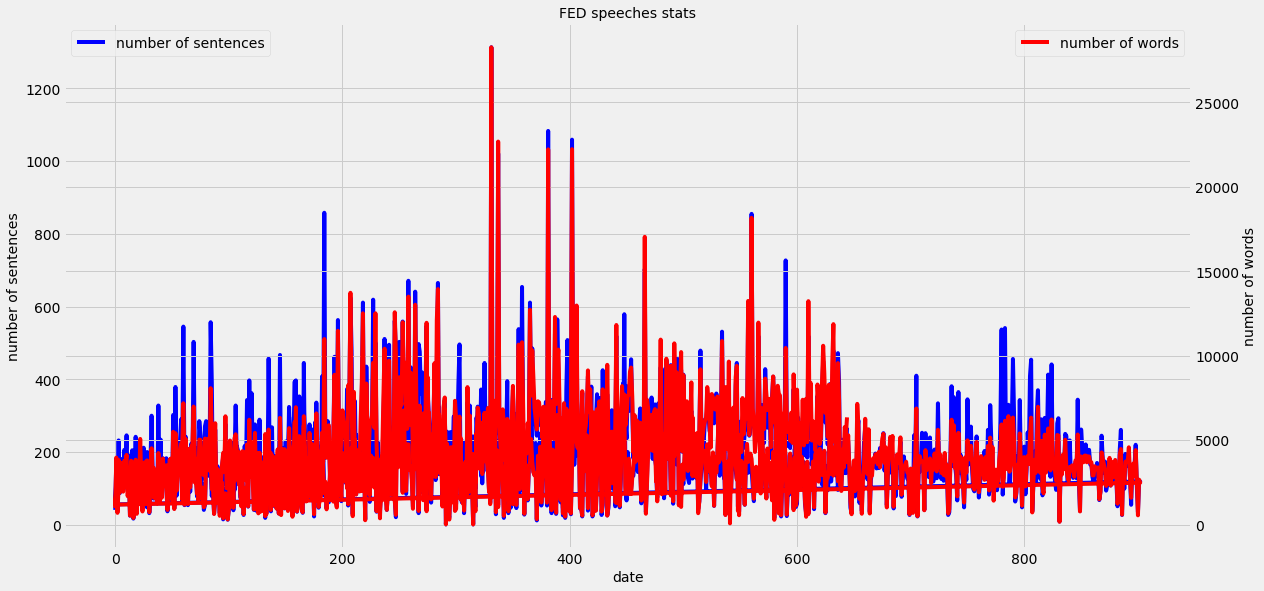

In [43]:
plt.rcParams["figure.figsize"] = (18, 9)
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(df_raw.index, df_raw["number of sentences"], 'b', label='number of sentences')
ax2.plot(df_raw.index, df_raw["number of words"], 'r', label='number of words')
plt.title('FED speeches stats', size='medium')
ax.legend(loc=2)
ax2.legend(loc=1)
ax.set_ylabel("number of sentences", size='medium')
ax2.set_ylabel("number of words", size='medium')
ax.set_xlabel("date", size='medium')
plt.show()

In [8]:
# df_speech = clean_speech_text(df_raw)
# df_speech.to_pickle("frb_speeches_all.pkl")

In [19]:
df_speech = pd.read_pickle("frb_speeches_all.pkl")
df_speech['speech_year'] = df_speech['speech_date'].str[-4:]
df_speech.drop(columns=['url', 'title', 'speaker', 'location'], inplace=True)
df_speech["speech_date"] = pd.to_datetime(df_speech["speech_date"])
df_speech.rename(columns={'speech_date': 'date'}, inplace=True)
df_speech = pd.merge(df_speech, mkt_df, how='left', on='date')
df_speech.dropna(inplace=True)
df_speech.reset_index(inplace=True, drop=True)
df_speech

,date,full_text,speech_year,SPY,VIX,TNX,IRX
0,2021-11-09,Opening remarks by Chair Powell at the Confere...,2021,-0.330537,3.252044,-4.342017,14.285714
1,2021-11-08,Good afternoon everyone It is a pleasure to jo...,2021,0.085372,4.490285,3.028217,-12.500000
2,2021-11-08,Opening Remarks by Chair Powell at the Gender ...,2021,0.085372,4.490285,3.028217,-12.500000
3,2021-11-08,Outlooks and Outcomes for the US Economy The U...,2021,0.085372,4.490285,3.028217,-12.500000
4,2021-10-22,Good morning I appreciate the opportunity to b...,2021,-0.103618,2.798135,-1.252983,0.000000
...,...,...,...,...,...,...,...
1474,1996-10-07,Remarks by Chairman Alan Greenspan US Treasur...,1996,0.111014,2.094595,0.804829,1.026694
1475,1996-10-02,Remarks by Governor Lawrence B Lindsey At the...,1996,0.679345,-1.583566,-0.588324,-1.408451
1476,1996-09-19,Remarks by Chairman Alan Greenspan Regulation...,1996,0.387862,1.071885,0.440335,-0.776699
1477,1996-06-18,Remarks by Governor Edward W Kelley Jr Develo...,1996,-0.817549,-0.057262,0.377523,0.396040


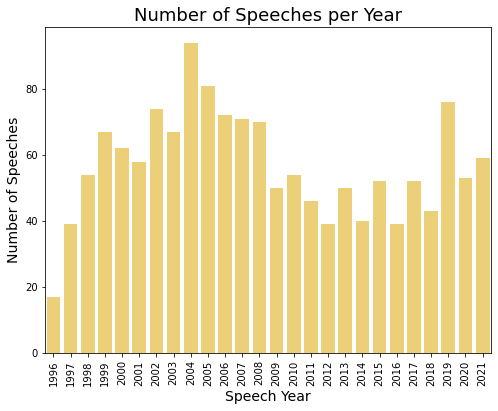

In [29]:
plot_speeches_per_year(df_speech)

Then we divide the market movement into two categories: 1 for upward and 0 for the rest.

In [188]:
for var in df_speech.columns[-4:]:
    df_speech[var] = df_speech[var].apply(lambda x: 1 if x > 0 else 0)

## Train/Test Split

The ratio I decided to split my data is 80/20, 80% of data as the training set, and 20% for the test set. The summary of the data split is given in the following cells.

In [59]:
def set_des(x_train_set, x_test_set, y_train_set, y_test_set):
    print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
        len(x_train_set), (len(x_train_set[y_train_set == 0]) / (len(x_train_set) * 1.)) * 100, (
                len(x_train_set[y_train_set == 1]) / (len(x_train_set) * 1.)) * 100))
    print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(
        len(x_test_set), (len(x_test_set[y_test_set == 0]) / (len(x_test_set) * 1.)) * 100, (
                len(x_test_set[y_test_set == 1]) / (len(x_test_set) * 1.)) * 100))

### SPY

In [60]:
x = df_speech['full_text']
y = df_speech['SPY']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 45.31% negative, 54.69% positive
Test set has total 296 entries with 49.66% negative, 50.34% positive


### TNX

In [61]:
x = df_speech['full_text']
y = df_speech['TNX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 51.56% negative, 48.44% positive
Test set has total 296 entries with 52.36% negative, 47.64% positive


### VIX

In [62]:
x = df_speech['full_text']
y = df_speech['VIX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 56.30% negative, 43.70% positive
Test set has total 296 entries with 53.04% negative, 46.96% positive


### IRX

In [ ]:
x = df_speech['full_text']
y = df_speech['VIX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

## Methodology

We have four y variables, and we apply two typical models: `tf-idf` & `logit` model and `word2vec` & `CNN` model on them.

### VIX: I

In [63]:
x = df_speech['full_text']
y = df_speech['VIX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 56.30% negative, 43.70% positive
Test set has total 296 entries with 53.04% negative, 46.96% positive


In [64]:
def labelize_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [65]:
all_x_w2v = labelize_ug(x, 'all')

In [66]:
model_ug_cbow = Word2Vec(sg=0, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1467212.78it/s]


In [67]:
% % time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1487620.05it/s]


Wall time: 50.1 s


In [68]:
model_ug_sg = Word2Vec(sg=1, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1498761.93it/s]


In [69]:
% % time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1478402.20it/s]


Wall time: 55.3 s


In [70]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [71]:
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [72]:
len(model_ug_cbow.wv.index_to_key)

27847

In [73]:
embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 27847 word vectors.


In [74]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [75]:
len(tokenizer.word_index)

27401

In [79]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [80]:
x_train_seq = pad_sequences(sequences, maxlen=len(length) + 10)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1193)


In [81]:
sequences_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_val, maxlen=len(length) + 10)

In [82]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [83]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 7s - loss: 2.4759 - accuracy: 0.4505 - val_loss: 0.6938 - val_accuracy: 0.5304 - 7s/epoch - 182ms/step
Epoch 2/5
37/37 - 6s - loss: 0.6387 - accuracy: 0.5985 - val_loss: 0.6935 - val_accuracy: 0.5304 - 6s/epoch - 167ms/step
Epoch 3/5
37/37 - 6s - loss: 0.5864 - accuracy: 0.6044 - val_loss: 0.7012 - val_accuracy: 0.5304 - 6s/epoch - 168ms/step
Epoch 4/5
37/37 - 6s - loss: 0.5692 - accuracy: 0.6044 - val_loss: 0.7055 - val_accuracy: 0.5304 - 6s/epoch - 168ms/step
Epoch 5/5
37/37 - 6s - loss: 0.5319 - accuracy: 0.6052 - val_loss: 0.7090 - val_accuracy: 0.5304 - 6s/epoch - 168ms/step


In [85]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 12s - loss: 0.7251 - accuracy: 0.5495 - val_loss: 0.6900 - val_accuracy: 0.5642 - 12s/epoch - 327ms/step
Epoch 2/5
37/37 - 12s - loss: 0.2122 - accuracy: 0.9518 - val_loss: 0.9650 - val_accuracy: 0.5473 - 12s/epoch - 312ms/step
Epoch 3/5
37/37 - 12s - loss: 0.0659 - accuracy: 0.9865 - val_loss: 0.8324 - val_accuracy: 0.5405 - 12s/epoch - 316ms/step
Epoch 4/5
37/37 - 11s - loss: 0.0390 - accuracy: 0.9932 - val_loss: 0.8241 - val_accuracy: 0.5101 - 11s/epoch - 309ms/step
Epoch 5/5
37/37 - 12s - loss: 0.0099 - accuracy: 0.9941 - val_loss: 0.8962 - val_accuracy: 0.5372 - 12s/epoch - 314ms/step


In [86]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 12s - loss: 2.9558 - accuracy: 0.5063 - val_loss: 0.6970 - val_accuracy: 0.5135 - 12s/epoch - 330ms/step
Epoch 2/5
37/37 - 12s - loss: 0.3422 - accuracy: 0.8943 - val_loss: 0.7877 - val_accuracy: 0.5068 - 12s/epoch - 317ms/step
Epoch 3/5
37/37 - 12s - loss: 0.1340 - accuracy: 0.9713 - val_loss: 0.7460 - val_accuracy: 0.5203 - 12s/epoch - 320ms/step
Epoch 4/5
37/37 - 12s - loss: 0.0243 - accuracy: 0.9958 - val_loss: 0.7963 - val_accuracy: 0.5372 - 12s/epoch - 332ms/step
Epoch 5/5
37/37 - 12s - loss: 0.0237 - accuracy: 0.9958 - val_loss: 0.8257 - val_accuracy: 0.5338 - 12s/epoch - 321ms/step


### VIX: II

In [87]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1193, 200)         20000000  
                                                                 
 conv1d (Conv1D)             (None, 1192, 100)         40100     
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [88]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 45, 200)           20000000  
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 100)           40100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [89]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 2s - loss: 0.7834 - accuracy: 0.5351 - val_loss: 0.6901 - val_accuracy: 0.5338 - 2s/epoch - 67ms/step
Epoch 2/5
37/37 - 2s - loss: 0.6462 - accuracy: 0.6255 - val_loss: 0.6967 - val_accuracy: 0.5743 - 2s/epoch - 55ms/step
Epoch 3/5
37/37 - 2s - loss: 0.6004 - accuracy: 0.6923 - val_loss: 0.7258 - val_accuracy: 0.5372 - 2s/epoch - 54ms/step
Epoch 4/5
37/37 - 2s - loss: 0.5657 - accuracy: 0.6923 - val_loss: 0.8494 - val_accuracy: 0.5270 - 2s/epoch - 55ms/step
Epoch 5/5
37/37 - 2s - loss: 0.4631 - accuracy: 0.8360 - val_loss: 0.7336 - val_accuracy: 0.5034 - 2s/epoch - 56ms/step


In [90]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 0.6883 - accuracy: 0.5630 - val_loss: 0.6926 - val_accuracy: 0.5304 - 8s/epoch - 220ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6617 - accuracy: 0.5959 - val_loss: 0.7119 - val_accuracy: 0.5304 - 8s/epoch - 210ms/step
Epoch 3/5
37/37 - 8s - loss: 0.5525 - accuracy: 0.8081 - val_loss: 0.7059 - val_accuracy: 0.5000 - 8s/epoch - 209ms/step
Epoch 4/5
37/37 - 8s - loss: 0.2763 - accuracy: 0.9527 - val_loss: 0.8112 - val_accuracy: 0.5135 - 8s/epoch - 206ms/step
Epoch 5/5
37/37 - 8s - loss: 0.0784 - accuracy: 0.9899 - val_loss: 0.9927 - val_accuracy: 0.5338 - 8s/epoch - 209ms/step


In [91]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 0.7810 - accuracy: 0.4945 - val_loss: 0.7213 - val_accuracy: 0.4831 - 8s/epoch - 221ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6270 - accuracy: 0.6450 - val_loss: 0.7396 - val_accuracy: 0.5270 - 8s/epoch - 210ms/step
Epoch 3/5
37/37 - 8s - loss: 0.5697 - accuracy: 0.6999 - val_loss: 0.7051 - val_accuracy: 0.5034 - 8s/epoch - 209ms/step
Epoch 4/5
37/37 - 8s - loss: 0.4952 - accuracy: 0.7861 - val_loss: 0.7137 - val_accuracy: 0.4932 - 8s/epoch - 210ms/step
Epoch 5/5
37/37 - 8s - loss: 0.3754 - accuracy: 0.9146 - val_loss: 0.7378 - val_accuracy: 0.4797 - 8s/epoch - 206ms/step


In [92]:
tweet_input = Input(shape=(len(length) + 10,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)(
    tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1193)]       0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 1193, 200)    20000000    ['input_1[0][0]']                
                                                                                                  
 conv1d_5 (Conv1D)              (None, 1192, 100)    40100       ['embedding_9[0][0]']            
                                                                                                  
 conv1d_6 (Conv1D)              (None, 1191, 100)    60100       ['embedding_9[0][0]']            
                                                                                              

In [93]:
from keras.callbacks import ModelCheckpoint

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
          validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.0906 - accuracy: 0.5266
Epoch 00001: val_accuracy improved from -inf to 0.55743, saving model to CNN_best_weights.01-0.5574.hdf5
37/37 [==============================] - 14s 376ms/step - loss: 1.0906 - accuracy: 0.5266 - val_loss: 0.6924 - val_accuracy: 0.5574
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.6195 - accuracy: 0.6610
Epoch 00002: val_accuracy did not improve from 0.55743
37/37 [==============================] - 13s 359ms/step - loss: 0.6195 - accuracy: 0.6610 - val_loss: 0.7033 - val_accuracy: 0.5203
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.8014
Epoch 00003: val_accuracy did not improve from 0.55743
37/37 [==============================] - 13s 358ms/step - loss: 0.4822 - accuracy: 0.8014 - val_loss: 0.7134 - val_accuracy: 0.5372
Epoch 4/5
37/37 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.8301
Epoch 00004: val_

In [94]:
loaded_CNN_model = load_model('CNN_best_weights.01-0.5574.hdf5')
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 0s 36ms/step - loss: 0.6924 - accuracy: 0.5574


[0.6924123167991638, 0.5574324131011963]

In [95]:
tvec = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [96]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [97]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)

LogisticRegression()

In [98]:
lr_with_tfidf.score(x_test_tfidf, y_test)

0.5168918918918919

In [99]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [100]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length) + 10)

In [101]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 0s 37ms/step - loss: 0.6924 - accuracy: 0.5574


[0.6924123167991638, 0.5574324131011963]

In [102]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

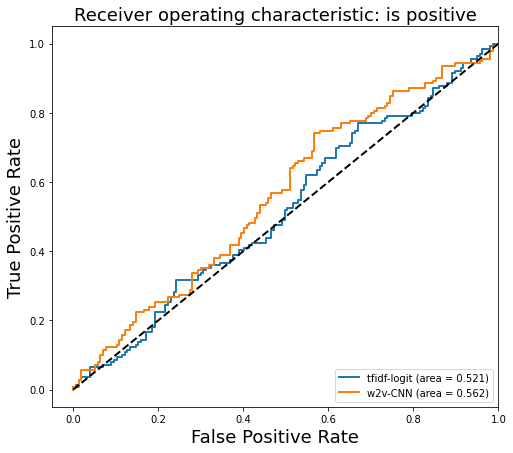

In [103]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### SPY: I

In [105]:
x = df_speech['full_text']
y = df_speech['SPY']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 45.31% negative, 54.69% positive
Test set has total 296 entries with 49.66% negative, 50.34% positive


In [106]:
def labelize_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [107]:
all_x_w2v = labelize_ug(x, 'all')

In [108]:
model_ug_cbow = Word2Vec(sg=0, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1482996.80it/s]


In [109]:
% % time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1474186.22it/s]


Wall time: 53.6 s


In [110]:
model_ug_sg = Word2Vec(sg=1, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1492631.28it/s]


In [111]:
% % time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1476642.61it/s]


Wall time: 59.4 s


In [112]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [113]:
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [114]:
len(model_ug_cbow.wv.index_to_key)

27847

In [115]:
embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 27847 word vectors.


In [116]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [117]:
len(tokenizer.word_index)

27401

In [118]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [119]:
x_train_seq = pad_sequences(sequences, maxlen=len(length) + 10)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1193)


In [120]:
sequences_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_val, maxlen=len(length) + 10)

In [121]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [122]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 7s - loss: 1.5337 - accuracy: 0.5063 - val_loss: 0.6915 - val_accuracy: 0.5034 - 7s/epoch - 202ms/step
Epoch 2/5
37/37 - 7s - loss: 0.4884 - accuracy: 0.6965 - val_loss: 0.7190 - val_accuracy: 0.5101 - 7s/epoch - 187ms/step
Epoch 3/5
37/37 - 7s - loss: 0.3084 - accuracy: 0.8284 - val_loss: 0.9311 - val_accuracy: 0.5135 - 7s/epoch - 188ms/step
Epoch 4/5
37/37 - 7s - loss: 0.0535 - accuracy: 0.9865 - val_loss: 0.8876 - val_accuracy: 0.4932 - 7s/epoch - 188ms/step
Epoch 5/5
37/37 - 7s - loss: 0.0101 - accuracy: 0.9983 - val_loss: 0.9386 - val_accuracy: 0.5135 - 7s/epoch - 179ms/step


In [123]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 13s - loss: 0.7190 - accuracy: 0.5165 - val_loss: 0.7045 - val_accuracy: 0.5034 - 13s/epoch - 340ms/step
Epoch 2/5
37/37 - 12s - loss: 0.1728 - accuracy: 0.9730 - val_loss: 0.8561 - val_accuracy: 0.5034 - 12s/epoch - 318ms/step
Epoch 3/5
37/37 - 12s - loss: 0.0471 - accuracy: 0.9932 - val_loss: 0.8552 - val_accuracy: 0.5169 - 12s/epoch - 315ms/step
Epoch 4/5
37/37 - 12s - loss: 0.0158 - accuracy: 0.9966 - val_loss: 0.8610 - val_accuracy: 0.5338 - 12s/epoch - 320ms/step
Epoch 5/5
37/37 - 12s - loss: 0.0174 - accuracy: 0.9975 - val_loss: 0.8503 - val_accuracy: 0.5270 - 12s/epoch - 316ms/step


In [124]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 14s - loss: 2.3511 - accuracy: 0.5292 - val_loss: 0.7001 - val_accuracy: 0.5000 - 14s/epoch - 377ms/step
Epoch 2/5
37/37 - 12s - loss: 0.6172 - accuracy: 0.6078 - val_loss: 0.7053 - val_accuracy: 0.5000 - 12s/epoch - 337ms/step
Epoch 3/5
37/37 - 13s - loss: 0.5995 - accuracy: 0.6095 - val_loss: 0.6943 - val_accuracy: 0.5034 - 13s/epoch - 338ms/step
Epoch 4/5
37/37 - 12s - loss: 0.5763 - accuracy: 0.6340 - val_loss: 0.7035 - val_accuracy: 0.5000 - 12s/epoch - 335ms/step
Epoch 5/5
37/37 - 12s - loss: 0.5632 - accuracy: 0.6534 - val_loss: 0.7045 - val_accuracy: 0.5000 - 12s/epoch - 333ms/step


### SPY: II

In [125]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 1193, 200)         20000000  
                                                                 
 conv1d_8 (Conv1D)           (None, 1192, 100)         40100     
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [126]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 45, 200)           20000000  
                                                                 
 conv1d_9 (Conv1D)           (None, 44, 100)           40100     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [127]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 3s - loss: 0.7742 - accuracy: 0.5275 - val_loss: 0.8195 - val_accuracy: 0.4966 - 3s/epoch - 73ms/step
Epoch 2/5
37/37 - 2s - loss: 0.6979 - accuracy: 0.5469 - val_loss: 0.7155 - val_accuracy: 0.4696 - 2s/epoch - 60ms/step
Epoch 3/5
37/37 - 2s - loss: 0.6068 - accuracy: 0.6999 - val_loss: 0.8708 - val_accuracy: 0.5034 - 2s/epoch - 60ms/step
Epoch 4/5
37/37 - 2s - loss: 0.5553 - accuracy: 0.7498 - val_loss: 0.7287 - val_accuracy: 0.4865 - 2s/epoch - 59ms/step
Epoch 5/5
37/37 - 2s - loss: 0.4758 - accuracy: 0.8123 - val_loss: 0.9516 - val_accuracy: 0.5068 - 2s/epoch - 60ms/step


In [128]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 9s - loss: 0.6910 - accuracy: 0.5317 - val_loss: 0.7045 - val_accuracy: 0.5034 - 9s/epoch - 233ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6618 - accuracy: 0.6061 - val_loss: 0.7079 - val_accuracy: 0.5068 - 8s/epoch - 220ms/step
Epoch 3/5
37/37 - 8s - loss: 0.5232 - accuracy: 0.8495 - val_loss: 0.7626 - val_accuracy: 0.5135 - 8s/epoch - 219ms/step
Epoch 4/5
37/37 - 8s - loss: 0.2103 - accuracy: 0.9721 - val_loss: 0.9202 - val_accuracy: 0.4865 - 8s/epoch - 218ms/step
Epoch 5/5
37/37 - 8s - loss: 0.0642 - accuracy: 0.9882 - val_loss: 1.2399 - val_accuracy: 0.5000 - 8s/epoch - 219ms/step


In [129]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 0.7387 - accuracy: 0.5224 - val_loss: 0.7274 - val_accuracy: 0.5068 - 8s/epoch - 225ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6364 - accuracy: 0.6407 - val_loss: 0.8194 - val_accuracy: 0.5034 - 8s/epoch - 214ms/step
Epoch 3/5
37/37 - 8s - loss: 0.5346 - accuracy: 0.7650 - val_loss: 0.7257 - val_accuracy: 0.5169 - 8s/epoch - 222ms/step
Epoch 4/5
37/37 - 8s - loss: 0.4561 - accuracy: 0.8090 - val_loss: 0.7378 - val_accuracy: 0.5338 - 8s/epoch - 220ms/step
Epoch 5/5
37/37 - 8s - loss: 0.3176 - accuracy: 0.9189 - val_loss: 0.8406 - val_accuracy: 0.5101 - 8s/epoch - 222ms/step


In [130]:
tweet_input = Input(shape=(len(length) + 10,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)(
    tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1193)]       0           []                               
                                                                                                  
 embedding_18 (Embedding)       (None, 1193, 200)    20000000    ['input_2[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 1192, 100)    40100       ['embedding_18[0][0]']           
                                                                                                  
 conv1d_14 (Conv1D)             (None, 1191, 100)    60100       ['embedding_18[0][0]']           
                                                                                            

In [131]:
from keras.callbacks import ModelCheckpoint

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
          validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.4426 - accuracy: 0.5207
Epoch 00001: val_accuracy improved from -inf to 0.50338, saving model to CNN_best_weights.01-0.5034.hdf5
37/37 [==============================] - 15s 376ms/step - loss: 1.4426 - accuracy: 0.5207 - val_loss: 0.8468 - val_accuracy: 0.5034
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.6221
Epoch 00002: val_accuracy did not improve from 0.50338
37/37 [==============================] - 13s 364ms/step - loss: 0.6804 - accuracy: 0.6221 - val_loss: 0.8860 - val_accuracy: 0.5034
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.7506
Epoch 00003: val_accuracy did not improve from 0.50338
37/37 [==============================] - 13s 362ms/step - loss: 0.5169 - accuracy: 0.7506 - val_loss: 0.7669 - val_accuracy: 0.4932
Epoch 4/5
37/37 [==============================] - ETA: 0s - loss: 0.3735 - accuracy: 0.8918
Epoch 00004: val_

In [132]:
loaded_CNN_model = load_model('CNN_best_weights.01-0.5034.hdf5')
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 0s 36ms/step - loss: 0.8468 - accuracy: 0.5034


[0.846837043762207, 0.5033783912658691]

In [133]:
tvec = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [134]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [135]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)

LogisticRegression()

In [136]:
lr_with_tfidf.score(x_test_tfidf, y_test)

0.4966216216216216

In [137]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [138]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length) + 10)

In [139]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 0s 37ms/step - loss: 0.8468 - accuracy: 0.5034


[0.846837043762207, 0.5033783912658691]

In [140]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

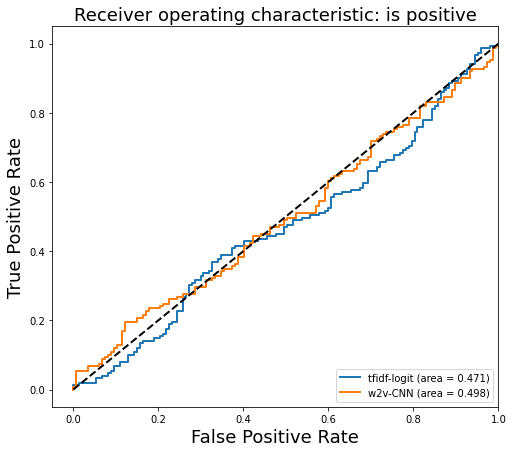

In [141]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### TNX: I

In [142]:
x = df_speech['full_text']
y = df_speech['TNX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 51.56% negative, 48.44% positive
Test set has total 296 entries with 52.36% negative, 47.64% positive


In [143]:
def labelize_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [144]:
all_x_w2v = labelize_ug(x, 'all')

In [145]:
model_ug_cbow = Word2Vec(sg=0, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<?, ?it/s]


In [146]:
% % time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1488333.88it/s]


Wall time: 52.6 s


In [147]:
model_ug_sg = Word2Vec(sg=1, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1479459.96it/s]


In [148]:
% % time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<?, ?it/s]


Wall time: 1min


In [149]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [150]:
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [151]:
len(model_ug_cbow.wv.index_to_key)

27847

In [152]:
embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 27847 word vectors.


In [153]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [154]:
len(tokenizer.word_index)

27401

In [155]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [156]:
x_train_seq = pad_sequences(sequences, maxlen=len(length) + 10)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1193)


In [157]:
sequences_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_val, maxlen=len(length) + 10)

In [158]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [159]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 10s - loss: 1.8125 - accuracy: 0.4928 - val_loss: 0.7357 - val_accuracy: 0.4899 - 10s/epoch - 278ms/step
Epoch 2/5
37/37 - 10s - loss: 0.6359 - accuracy: 0.5486 - val_loss: 0.7371 - val_accuracy: 0.4696 - 10s/epoch - 268ms/step
Epoch 3/5
37/37 - 10s - loss: 0.6280 - accuracy: 0.5621 - val_loss: 0.7382 - val_accuracy: 0.4696 - 10s/epoch - 267ms/step
Epoch 4/5
37/37 - 10s - loss: 0.6270 - accuracy: 0.5613 - val_loss: 0.7387 - val_accuracy: 0.4696 - 10s/epoch - 265ms/step
Epoch 5/5
37/37 - 10s - loss: 0.6262 - accuracy: 0.5621 - val_loss: 0.7394 - val_accuracy: 0.4696 - 10s/epoch - 268ms/step


In [160]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 16s - loss: 0.7374 - accuracy: 0.5199 - val_loss: 0.7023 - val_accuracy: 0.5169 - 16s/epoch - 422ms/step
Epoch 2/5
37/37 - 15s - loss: 0.0996 - accuracy: 0.9890 - val_loss: 0.8386 - val_accuracy: 0.5068 - 15s/epoch - 398ms/step
Epoch 3/5
37/37 - 14s - loss: 0.0124 - accuracy: 0.9932 - val_loss: 0.8414 - val_accuracy: 0.5507 - 14s/epoch - 384ms/step
Epoch 4/5
37/37 - 14s - loss: 0.0109 - accuracy: 0.9941 - val_loss: 0.8701 - val_accuracy: 0.5000 - 14s/epoch - 389ms/step
Epoch 5/5
37/37 - 15s - loss: 0.0086 - accuracy: 0.9941 - val_loss: 0.8476 - val_accuracy: 0.5304 - 15s/epoch - 397ms/step


In [161]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 16s - loss: 2.5773 - accuracy: 0.4979 - val_loss: 1.4746 - val_accuracy: 0.5304 - 16s/epoch - 445ms/step
Epoch 2/5
37/37 - 15s - loss: 0.2067 - accuracy: 0.9265 - val_loss: 1.6325 - val_accuracy: 0.5101 - 15s/epoch - 403ms/step
Epoch 3/5
37/37 - 15s - loss: 0.0189 - accuracy: 0.9932 - val_loss: 1.5772 - val_accuracy: 0.5169 - 15s/epoch - 403ms/step
Epoch 4/5
37/37 - 15s - loss: 0.0057 - accuracy: 0.9966 - val_loss: 1.5678 - val_accuracy: 0.5034 - 15s/epoch - 396ms/step
Epoch 5/5
37/37 - 14s - loss: 0.0050 - accuracy: 0.9966 - val_loss: 1.5759 - val_accuracy: 0.5068 - 14s/epoch - 379ms/step


### TNX: II

In [162]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 1193, 200)         20000000  
                                                                 
 conv1d_16 (Conv1D)          (None, 1192, 100)         40100     
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [163]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 45, 200)           20000000  
                                                                 
 conv1d_17 (Conv1D)          (None, 44, 100)           40100     
                                                                 
 global_max_pooling1d_14 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [164]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 4s - loss: 0.7932 - accuracy: 0.4717 - val_loss: 0.7034 - val_accuracy: 0.5101 - 4s/epoch - 99ms/step
Epoch 2/5
37/37 - 3s - loss: 0.6540 - accuracy: 0.6272 - val_loss: 0.7029 - val_accuracy: 0.5203 - 3s/epoch - 87ms/step
Epoch 3/5
37/37 - 3s - loss: 0.6069 - accuracy: 0.7092 - val_loss: 0.7096 - val_accuracy: 0.5068 - 3s/epoch - 87ms/step
Epoch 4/5
37/37 - 3s - loss: 0.5443 - accuracy: 0.8301 - val_loss: 0.7293 - val_accuracy: 0.4831 - 3s/epoch - 87ms/step
Epoch 5/5
37/37 - 3s - loss: 0.4871 - accuracy: 0.8022 - val_loss: 0.8987 - val_accuracy: 0.5169 - 3s/epoch - 87ms/step


In [165]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 0.6974 - accuracy: 0.4886 - val_loss: 0.7038 - val_accuracy: 0.5236 - 8s/epoch - 219ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6806 - accuracy: 0.5461 - val_loss: 0.6928 - val_accuracy: 0.5338 - 8s/epoch - 208ms/step
Epoch 3/5
37/37 - 8s - loss: 0.6002 - accuracy: 0.7819 - val_loss: 0.7230 - val_accuracy: 0.4797 - 8s/epoch - 207ms/step
Epoch 4/5
37/37 - 8s - loss: 0.3489 - accuracy: 0.9180 - val_loss: 0.8208 - val_accuracy: 0.4696 - 8s/epoch - 207ms/step
Epoch 5/5
37/37 - 8s - loss: 0.1036 - accuracy: 0.9856 - val_loss: 1.0115 - val_accuracy: 0.5068 - 8s/epoch - 207ms/step


In [166]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 0.7559 - accuracy: 0.5030 - val_loss: 0.7145 - val_accuracy: 0.5000 - 8s/epoch - 219ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6312 - accuracy: 0.6484 - val_loss: 0.7056 - val_accuracy: 0.5101 - 8s/epoch - 206ms/step
Epoch 3/5
37/37 - 8s - loss: 0.5365 - accuracy: 0.7828 - val_loss: 0.7990 - val_accuracy: 0.5439 - 8s/epoch - 208ms/step
Epoch 4/5
37/37 - 8s - loss: 0.4304 - accuracy: 0.8673 - val_loss: 0.7372 - val_accuracy: 0.5000 - 8s/epoch - 207ms/step
Epoch 5/5
37/37 - 8s - loss: 0.3051 - accuracy: 0.9527 - val_loss: 0.7914 - val_accuracy: 0.5135 - 8s/epoch - 210ms/step


In [167]:
tweet_input = Input(shape=(len(length) + 10,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)(
    tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1193)]       0           []                               
                                                                                                  
 embedding_27 (Embedding)       (None, 1193, 200)    20000000    ['input_3[0][0]']                
                                                                                                  
 conv1d_21 (Conv1D)             (None, 1192, 100)    40100       ['embedding_27[0][0]']           
                                                                                                  
 conv1d_22 (Conv1D)             (None, 1191, 100)    60100       ['embedding_27[0][0]']           
                                                                                            

In [168]:
from keras.callbacks import ModelCheckpoint

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
          validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.2066 - accuracy: 0.5013
Epoch 00001: val_accuracy improved from -inf to 0.47973, saving model to CNN_best_weights.01-0.4797.hdf5
37/37 [==============================] - 15s 387ms/step - loss: 1.2066 - accuracy: 0.5013 - val_loss: 0.8367 - val_accuracy: 0.4797
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6298
Epoch 00002: val_accuracy improved from 0.47973 to 0.48311, saving model to CNN_best_weights.02-0.4831.hdf5
37/37 [==============================] - 14s 382ms/step - loss: 0.6563 - accuracy: 0.6298 - val_loss: 0.7734 - val_accuracy: 0.4831
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.7540
Epoch 00003: val_accuracy improved from 0.48311 to 0.48986, saving model to CNN_best_weights.03-0.4899.hdf5
37/37 [==============================] - 15s 412ms/step - loss: 0.5026 - accuracy: 0.7540 - val_loss: 0.7208 - val_accuracy: 0.4899
Epoc

In [169]:
loaded_CNN_model = load_model('CNN_best_weights.01-0.4797.hdf5')
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 1s 70ms/step - loss: 0.8367 - accuracy: 0.4797


[0.8366792798042297, 0.4797297418117523]

In [170]:
tvec = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [171]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [172]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)

LogisticRegression()

In [173]:
lr_with_tfidf.score(x_test_tfidf, y_test)

0.47635135135135137

In [174]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [175]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length) + 10)

In [176]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 1s 67ms/step - loss: 0.8367 - accuracy: 0.4797


[0.8366792798042297, 0.4797297418117523]

In [177]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

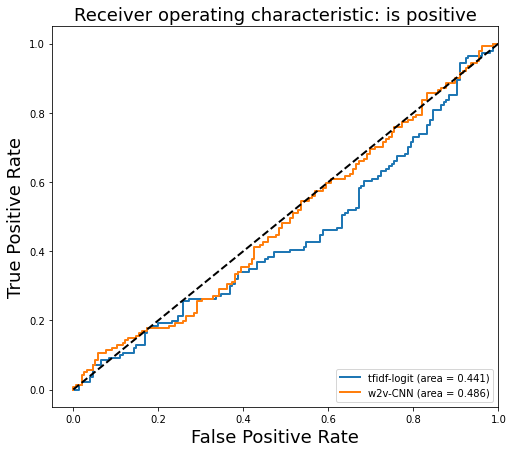

In [178]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### IRX: I

In [189]:
x = df_speech['full_text']
y = df_speech['IRX']
SEED = 2000
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=SEED)
set_des(x_train, x_test, y_train, y_test)

Train set has total 1183 entries with 61.88% negative, 38.12% positive
Test set has total 296 entries with 59.12% negative, 40.88% positive


In [190]:
def labelize_ug(tweets, label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [191]:
all_x_w2v = labelize_ug(x, 'all')

In [192]:
model_ug_cbow = Word2Vec(sg=0, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1466519.06it/s]


In [193]:
% % time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1478402.20it/s]


Wall time: 51.7 s


In [194]:
model_ug_sg = Word2Vec(sg=1, negative=5, window=2, min_count=2, workers=16, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1471039.98it/s]


In [195]:
% % time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|█████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 1481226.27it/s]


Wall time: 57.7 s


In [196]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [197]:
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [198]:
len(model_ug_cbow.wv.index_to_key)

27847

In [199]:
embeddings_index = {}
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 27847 word vectors.


In [200]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [201]:
len(tokenizer.word_index)

27401

In [202]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [203]:
x_train_seq = pad_sequences(sequences, maxlen=len(length) + 10)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1183, 1193)


In [204]:
sequences_val = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_val, maxlen=len(length) + 10)

In [205]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [206]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 3.4346 - accuracy: 0.5139 - val_loss: 0.8769 - val_accuracy: 0.4628 - 8s/epoch - 219ms/step
Epoch 2/5
37/37 - 8s - loss: 0.2070 - accuracy: 0.9239 - val_loss: 0.9405 - val_accuracy: 0.5541 - 8s/epoch - 210ms/step
Epoch 3/5
37/37 - 8s - loss: 0.0299 - accuracy: 0.9975 - val_loss: 1.0633 - val_accuracy: 0.5709 - 8s/epoch - 207ms/step
Epoch 4/5
37/37 - 8s - loss: 0.0170 - accuracy: 0.9975 - val_loss: 1.1726 - val_accuracy: 0.5642 - 8s/epoch - 207ms/step
Epoch 5/5
37/37 - 8s - loss: 0.0116 - accuracy: 0.9983 - val_loss: 1.2061 - val_accuracy: 0.5676 - 8s/epoch - 208ms/step


In [207]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 13s - loss: 0.6829 - accuracy: 0.5917 - val_loss: 0.7255 - val_accuracy: 0.5845 - 13s/epoch - 355ms/step
Epoch 2/5
37/37 - 13s - loss: 0.1228 - accuracy: 0.9679 - val_loss: 1.3236 - val_accuracy: 0.5777 - 13s/epoch - 341ms/step
Epoch 3/5
37/37 - 13s - loss: 0.0344 - accuracy: 0.9932 - val_loss: 1.1802 - val_accuracy: 0.5777 - 13s/epoch - 340ms/step
Epoch 4/5
37/37 - 12s - loss: 0.0145 - accuracy: 0.9975 - val_loss: 1.0696 - val_accuracy: 0.5372 - 12s/epoch - 333ms/step
Epoch 5/5
37/37 - 12s - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.9796 - val_accuracy: 0.5135 - 12s/epoch - 332ms/step


In [208]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 13s - loss: 3.5083 - accuracy: 0.4818 - val_loss: 0.9003 - val_accuracy: 0.4324 - 13s/epoch - 357ms/step
Epoch 2/5
37/37 - 13s - loss: 0.2698 - accuracy: 0.9070 - val_loss: 0.9296 - val_accuracy: 0.5541 - 13s/epoch - 341ms/step
Epoch 3/5
37/37 - 12s - loss: 0.0687 - accuracy: 0.9949 - val_loss: 0.9497 - val_accuracy: 0.5270 - 12s/epoch - 336ms/step
Epoch 4/5
37/37 - 13s - loss: 0.0111 - accuracy: 0.9975 - val_loss: 1.1297 - val_accuracy: 0.5811 - 13s/epoch - 338ms/step
Epoch 5/5
37/37 - 13s - loss: 0.0191 - accuracy: 0.9975 - val_loss: 1.0921 - val_accuracy: 0.5574 - 13s/epoch - 351ms/step


### IRX: II

In [209]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 1193, 200)         20000000  
                                                                 
 conv1d_24 (Conv1D)          (None, 1192, 100)         40100     
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [210]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 45, 200)           20000000  
                                                                 
 conv1d_25 (Conv1D)          (None, 44, 100)           40100     
                                                                 
 global_max_pooling1d_21 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                                 
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [211]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 3s - loss: 0.7674 - accuracy: 0.5503 - val_loss: 0.6895 - val_accuracy: 0.5845 - 3s/epoch - 86ms/step
Epoch 2/5
37/37 - 3s - loss: 0.6579 - accuracy: 0.6162 - val_loss: 0.7789 - val_accuracy: 0.5912 - 3s/epoch - 75ms/step
Epoch 3/5
37/37 - 3s - loss: 0.5752 - accuracy: 0.7033 - val_loss: 0.7183 - val_accuracy: 0.4831 - 3s/epoch - 74ms/step
Epoch 4/5
37/37 - 3s - loss: 0.5057 - accuracy: 0.7828 - val_loss: 0.7415 - val_accuracy: 0.5743 - 3s/epoch - 74ms/step
Epoch 5/5
37/37 - 3s - loss: 0.4290 - accuracy: 0.8555 - val_loss: 0.7257 - val_accuracy: 0.5405 - 3s/epoch - 74ms/step


In [212]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=len(length) + 10)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 0.6679 - accuracy: 0.6205 - val_loss: 0.6812 - val_accuracy: 0.5912 - 8s/epoch - 228ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6381 - accuracy: 0.6238 - val_loss: 0.6925 - val_accuracy: 0.5169 - 8s/epoch - 214ms/step
Epoch 3/5
37/37 - 8s - loss: 0.5477 - accuracy: 0.7278 - val_loss: 0.7013 - val_accuracy: 0.5541 - 8s/epoch - 214ms/step
Epoch 4/5
37/37 - 8s - loss: 0.2947 - accuracy: 0.9366 - val_loss: 0.8015 - val_accuracy: 0.5135 - 8s/epoch - 214ms/step
Epoch 5/5
37/37 - 8s - loss: 0.0834 - accuracy: 0.9882 - val_loss: 1.0188 - val_accuracy: 0.5439 - 8s/epoch - 216ms/step


In [213]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_test_seq, y_test), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
37/37 - 8s - loss: 0.7795 - accuracy: 0.5368 - val_loss: 0.7476 - val_accuracy: 0.5912 - 8s/epoch - 227ms/step
Epoch 2/5
37/37 - 8s - loss: 0.6369 - accuracy: 0.6314 - val_loss: 0.7080 - val_accuracy: 0.5101 - 8s/epoch - 216ms/step
Epoch 3/5
37/37 - 8s - loss: 0.5549 - accuracy: 0.7405 - val_loss: 0.7731 - val_accuracy: 0.5878 - 8s/epoch - 211ms/step
Epoch 4/5
37/37 - 8s - loss: 0.4654 - accuracy: 0.8309 - val_loss: 0.7196 - val_accuracy: 0.5304 - 8s/epoch - 212ms/step
Epoch 5/5
37/37 - 8s - loss: 0.3446 - accuracy: 0.9434 - val_loss: 0.8356 - val_accuracy: 0.5777 - 8s/epoch - 212ms/step


In [214]:
tweet_input = Input(shape=(len(length) + 10,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=len(length) + 10, trainable=True)(
    tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1193)]       0           []                               
                                                                                                  
 embedding_36 (Embedding)       (None, 1193, 200)    20000000    ['input_4[0][0]']                
                                                                                                  
 conv1d_29 (Conv1D)             (None, 1192, 100)    40100       ['embedding_36[0][0]']           
                                                                                                  
 conv1d_30 (Conv1D)             (None, 1191, 100)    60100       ['embedding_36[0][0]']           
                                                                                            

In [215]:
from keras.callbacks import ModelCheckpoint

filepath = "CNN_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
          validation_data=(x_test_seq, y_test), callbacks=[checkpoint])

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.3133 - accuracy: 0.5325
Epoch 00001: val_accuracy improved from -inf to 0.40878, saving model to CNN_best_weights.01-0.4088.hdf5
37/37 [==============================] - 15s 393ms/step - loss: 1.3133 - accuracy: 0.5325 - val_loss: 1.0846 - val_accuracy: 0.4088
Epoch 2/5
37/37 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.6281
Epoch 00002: val_accuracy improved from 0.40878 to 0.58784, saving model to CNN_best_weights.02-0.5878.hdf5
37/37 [==============================] - 15s 395ms/step - loss: 0.7150 - accuracy: 0.6281 - val_loss: 0.7234 - val_accuracy: 0.5878
Epoch 3/5
37/37 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.8064
Epoch 00003: val_accuracy did not improve from 0.58784
37/37 [==============================] - 14s 378ms/step - loss: 0.4917 - accuracy: 0.8064 - val_loss: 0.7336 - val_accuracy: 0.5811
Epoch 4/5
37/37 [==============================] - ETA: 0

In [231]:
loaded_CNN_model = load_model('CNN_best_weights.02-0.5878.hdf5')
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 1s 49ms/step - loss: 0.7234 - accuracy: 0.5878


[0.7234224081039429, 0.587837815284729]

In [232]:
tvec = TfidfVectorizer(max_features=100000, ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(max_features=100000, ngram_range=(1, 3))

In [233]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [234]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf, y_train)

LogisticRegression()

In [235]:
lr_with_tfidf.score(x_test_tfidf, y_test)

0.581081081081081

In [236]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [237]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=len(length) + 10)

In [238]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

10/10 [==============================] - 1s 51ms/step - loss: 0.7234 - accuracy: 0.5878


[0.7234224081039429, 0.587837815284729]

In [239]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

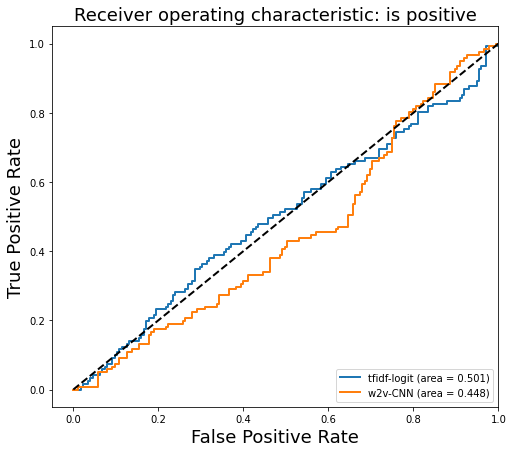

In [240]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:, 1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8, 7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()